In [1]:
import torch
import torchaudio
import math
from IPython.display import Audio
import causal_improved_sudormrf_v3
import time as t
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Function that loads the multi-GPU saved SudorRMRF_causal_v3 weights for CPU inference
def load_sudormrf_causal_cpu(model_path):
    # 1: declarem el model (instanciem la classe)
    model = causal_improved_sudormrf_v3.CausalSuDORMRF(
        in_audio_channels=1,
        out_channels=512,
        in_channels=256,
        num_blocks=16,
        upsampling_depth=5,
        enc_kernel_size=21,
        enc_num_basis=512,
        num_sources=1,
        )
    # 2: el passem a DataParallel perquè es va guardar com un DataParallel
    model = torch.nn.DataParallel(model)
    # 3: carreguem els pesos

    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    # 4: El pasem a GPU. Tu podries provar torch.device("mps") que seria la teva GPU
    device = torch.device("cpu")
    model = model.module.to(device)

    # 5: posem en mode Evaluació (es desactiva dropout i coses així)
    model.eval()
    return model

In [3]:
model_path = 'e39_sudo_whamr_16k_enhnoisy_augment.pt'
model = load_sudormrf_causal_cpu(model_path)

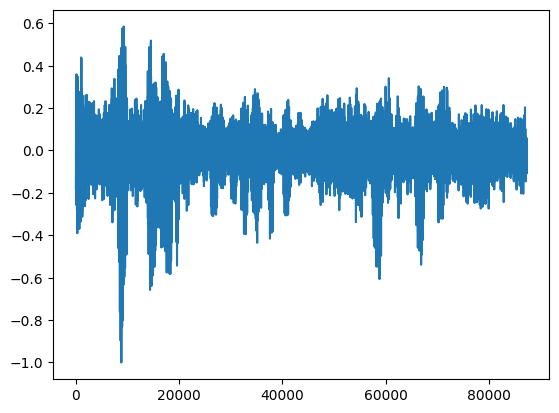

In [4]:
# carreguem speech i noise, fem una mixture:
speech, fs = torchaudio.load('speech.wav')
noise, fs = torchaudio.load('noise.wav')
mixture1 = speech + noise
mixture1 /= torch.max(torch.abs(mixture1))
plt.plot(mixture1.numpy()[0])

In [5]:
# guardem l'energia de la mixture per poder normalitzar la sortida del model
ini_nrg = torch.sum(mixture1 ** 2)
print(ini_nrg)

tensor(702.2484)


In [6]:
Audio(mixture1.numpy(), rate=fs)


In [7]:
# standarditzem la mixture (normalitzacr)
mixture = (mixture1 - torch.mean(mixture1)) / torch.std(mixture1)

In [8]:
torch.backends.mps.is_available()

True

In [9]:
# apliquem el model
import time

ini = time.time()
#mixture = mixture1.to('mps')
denoised = model(mixture.unsqueeze(0)).detach()
fini = time.time()
print(fini-ini)

1.6491830348968506


In [10]:
# de-normalitzem
denoised /= torch.sqrt(torch.sum(denoised ** 2) / ini_nrg)

In [11]:
Audio(denoised.cpu().numpy()[0,0], rate=fs)
audio = denoised.cpu()[0,:,:]

In [12]:
#Calulem la métrica SDR
#from torchmetrics.functional.audio import signal_distortion_ratio
#den = denoised.cpu()[0,:,:]

#res = signal_distortion_ratio(den, mixture)
#print(res)

In [13]:
# guardem el .wav
torchaudio.save('denoised.wav', denoised.cpu()[0,:,:], sample_rate=fs)